# Iterative Approach for Unet Training 

------

## Overview



The purpose of this learn.ipynb notebook is to investigate whether an image can exhibit a preference for being segmented more effectively using a UNet model trained on polar or cartesian-dominant images.




-----


## File Structure
```
data
└── endoscopic
    ├── cartesian
    │   ├── image
    │   └── label
    └── polar
        ├── image
        └── label
```

Inside of each end folder there are 956 images, named as `0.tif` to `955.tif`
and I believe, for now, the naming of the images are one to one correctly matched, meaning the ``/data/endoscopic/**cartesian**/image/0.tif`` is transformed from `/data/endoscopic/**polar**/image/0.tif`

Instead of putting a seperate set of images aside to be test set, we chose to use k-fold cross validation.

In [1]:
from defines import *
from model import *
from data import *
import sys

import cv2
from numpy import loadtxt
from keras.models import load_model
from PIL import Image

from sklearn.model_selection import KFold
from skimage.io import imread
from skimage import img_as_ubyte
from skimage.transform import resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import math
import shutil

In [ ]:
# Import from files and libraries

In [2]:
#run this if your computer has a cuda visible device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
print(PARAM_SYSTEM_TIME)

In [ ]:
# Test code for correct file structure setup

In [ ]:
# Visualize folder tree in current directory
os.system("tree -d")

In [ ]:
#count of files in data directories
os.system("ls " + os.path.join(PARAM_PATH_CARTE,PARAM_IMG_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_CARTE,PARAM_MSK_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_POLAR,PARAM_IMG_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_POLAR,PARAM_MSK_FOLDER) + " | wc -l")


*Expected Output:
7404\
7404\
7404\
7404\
*

----

## File Relocation

In the following block, the code loads in one analysis file from previous research. 

### #File name postfix
_C_ is the dice scores of the predictions generated by Unet C: this Unet C is trained using all 7404 images, in their cartesian form. The raw image was directly input into the Unet and the prediction was generated.

_P_ is the dice scores of the predictions generated by Unet P: this Unet P is trained using all 7404 images but in their polar form. The raw images were transformed, and then input for prediction. The prediction is in polar space.

_P2C_ is the dice scores of the predictions generated by the same Unet P as mentioned above, but the dice score is generated by transforming the prediction back to cartesian, and compared to their original label.

In [3]:
#file_name = 'analysis_dice_back_Test_C.npy'
#file_name = 'analysis_dice_back_Test_P.npy'
#file_name = 'analysis_dice_back_Test_P2C.npy'
file_name = 'analysis_dice_back_Train_P.npy'

np_file = os.path.join(PARAM_PATH_SCORES, file_name)
#load npy file
img_score = np.load(np_file)

#sort scores in descending order and store index
sorted_score = np.flip(np.argsort(img_score))

#------DEBUG--------
#print(len(sorted_score))


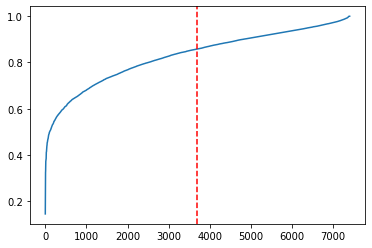

In [4]:
#This sort the image score and visulize it
x_range = 7404
img_score_visual = np.sort(img_score)
fig, ax = plt.subplots()
ax.plot(img_score_visual[0:x_range])
ax.axvline(x=(x_range/2), color='r', linestyle='--', label='Horizontal Line at y=5')

In [87]:

for item in img_score:
    if item == 1:
        print('!')

!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!


The `sorted_score` should be a list of length 7404, sorted by the method we chose

In [5]:
sorted_score = pd.DataFrame(sorted_score)

#fetch top polar dominant and non-polar dominant image
num_polar = round(len(sorted_score)/2)
num_cartesian = len(sorted_score) - num_polar
dfPolar = sorted_score.head(num_polar)
dfCartesian = sorted_score.tail(num_cartesian)
#print("Polar: \n", dfPolar)
#print("Cartesian: \n", dfCartesian)

Now in `dfPolar` should be the best half of images (filename), which performs better than the other half, according to the data we used above. In `dfCartesian` there's the other half.

In [6]:
from filePrep import *

K = 5

checkNcreateTempFolder(PARAM_PATH_TEMP_POLAR, K)
checkNcreateTempFolder(PARAM_PATH_TEMP_CARTE, K)

The two lines creates the new temporary folder.
Instead of making kfolds later, the kfolds is assigned now.

In [7]:
kf = KFold(n_splits = K, shuffle = True, random_state = 42) 

Use the KFold package to assign the paramters like n_splits and so.


In [8]:
i = 0
for train_index,test_index in kf.split(dfPolar):
    fillFolder(test_index, dfPolar, PARAM_PATH_POLAR, PARAM_PATH_CARTE, PARAM_PATH_TEMP_POLAR, i)
    i += 1
i = 0
print('------------------------------------')
for train_index,test_index in kf.split(dfCartesian):
    fillFolder(test_index, dfCartesian, PARAM_PATH_POLAR, PARAM_PATH_CARTE, PARAM_PATH_TEMP_CARTE, i)
    i += 1

------------------------------------


At this point we should have all `k-folds` set up. The next step is to write a training loop.


Due to the limitation of flow_from_directory, which, it does not allow the combination of multiple directories. And, the limitation of my knowledge of flow_from_dataframe. **I believe this is solvable using flow_from_dataframe** I decide to move training set into a separate temporary folder when training.

In [9]:
batch_size = 4
PARAM_BETA_TEST_NUM = 6
data_gen_args = dict(rotation_range = 50,      # TODO: improve the data augmentation
                width_shift_range =0.2,
                height_shift_range =0.2,
                shear_range = 0.35,
                zoom_range = 0.05,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
#Train polar models
working_parent_folder = PARAM_PATH_TEMP_POLAR
Polar_history = []
for i in range(K):
    working_test_folder_i = os.path.join(working_parent_folder, str(i), PARAM_SUB_FOLDER_POLAR)
    temp_folder_path = os.path.join(working_parent_folder,'temp')
    os.mkdir(temp_folder_path)
    for j in range(K):
        if i != j:
            for subfolder_name in ['image','label']:
                subfolder_path = os.path.join(working_parent_folder,str(j),'polar',subfolder_name)
                temp_subfolder_path = os.path.join(temp_folder_path,subfolder_name)
                for root, dirs, files in os.walk(subfolder_path):
                    for file in files:
                        src_file = os.path.join(root, file)
                        dest_file = os.path.join(temp_subfolder_path,os.path.relpath(src_file, subfolder_path))
                        os.makedirs(os.path.dirname(dest_file), exist_ok=True)
                        shutil.copy(src_file, dest_file)
    test_gene = trainGenerator(batch_size, temp_folder_path, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, data_gen_args)
    model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
    model_checkpoint = ModelCheckpoint(os.path.join(working_parent_folder,str(i),'checkpoint.hdf5'), monitor = 'loss', verbose=1, save_best_only=True)
    test_run = model.fit(test_gene, verbose = 1, steps_per_epoch = 100, epochs = 100, callbacks = [model_checkpoint])
    Polar_history.append(test_run)
    shutil.rmtree(temp_folder_path)
    
#Train cartesian models
data_gen_args = dict(rotation_range = 80,      # TODO: improve the data augmentation
                width_shift_range =0.02,
                height_shift_range =0.02,
                shear_range = 0.35,
                zoom_range = 0.075,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
working_parent_folder = PARAM_PATH_TEMP_CARTE
Cartesian_history = []
for i in range(K):
    working_test_folder_i = os.path.join(working_parent_folder, str(i), PARAM_SUB_FOLDER_CARTE)
    temp_folder_path = os.path.join(working_parent_folder,'temp')
    os.mkdir(temp_folder_path)
    for j in range(K):
        if i != j:
            for subfolder_name in ['image','label']:
                subfolder_path = os.path.join(working_parent_folder,str(j),'carte',subfolder_name)
                temp_subfolder_path = os.path.join(temp_folder_path,subfolder_name)
                for root, dirs, files in os.walk(subfolder_path):
                    for file in files:
                        src_file = os.path.join(root, file)
                        dest_file = os.path.join(temp_subfolder_path,os.path.relpath(src_file, subfolder_path))
                        os.makedirs(os.path.dirname(dest_file), exist_ok=True)
                        shutil.copy(src_file, dest_file)
    test_gene = trainGenerator(batch_size, temp_folder_path, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, data_gen_args)
    model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
    model_checkpoint = ModelCheckpoint(os.path.join(working_parent_folder,str(i),'checkpoint.hdf5'), monitor = 'loss', verbose=1, save_best_only=True)
    test_run = model.fit(test_gene, verbose = 1, steps_per_epoch = 100, epochs = 100, callbacks = [model_checkpoint])
    Cartesian_history.append(test_run)
    shutil.rmtree(temp_folder_path)

2023-09-27 20:14:45.942045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-27 20:14:45.964479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-27 20:14:45.964614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-27 20:14:45.965174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 2961 images belonging to 1 classes.
Found 2961 images belonging to 1 classes.
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph

2023-09-27 20:14:49.035829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-09-27 20:14:49.284688: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


100/100 [==============================] - ETA: 0s - loss: 0.7795 - accuracy: 0.8602 - dice_coef_loss: 0.7795
Epoch 1: loss improved from inf to 0.77948, saving model to ./temp/polar_Dom/0/checkpoint.hdf5
100/100 [==============================] - 31s 262ms/step - loss: 0.7795 - accuracy: 0.8602 - dice_coef_loss: 0.7795
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.8527 - dice_coef_loss: 0.6982
Epoch 2: loss improved from 0.77948 to 0.69818, saving model to ./temp/polar_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.6982 - accuracy: 0.8527 - dice_coef_loss: 0.6982
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.8607 - dice_coef_loss: 0.6716
Epoch 3: loss improved from 0.69818 to 0.67161, saving model to ./temp/polar_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 268ms/step - loss: 0.6716 - accuracy: 0.8607 - dice_coef_loss: 0.6716
Ep

100/100 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.9130 - dice_coef_loss: 0.5907
Epoch 27: loss did not improve from 0.57542
100/100 [==============================] - 26s 259ms/step - loss: 0.5907 - accuracy: 0.9130 - dice_coef_loss: 0.5907
Epoch 28/100
100/100 [==============================] - ETA: 0s - loss: 0.5822 - accuracy: 0.9078 - dice_coef_loss: 0.5822
Epoch 28: loss did not improve from 0.57542
100/100 [==============================] - 26s 259ms/step - loss: 0.5822 - accuracy: 0.9078 - dice_coef_loss: 0.5822
Epoch 29/100
100/100 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.9138 - dice_coef_loss: 0.5623
Epoch 29: loss improved from 0.57542 to 0.56226, saving model to ./temp/polar_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5623 - accuracy: 0.9138 - dice_coef_loss: 0.5623
Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 0.5810 - accuracy: 0.9032 - dice_

100/100 [==============================] - ETA: 0s - loss: 0.5402 - accuracy: 0.9186 - dice_coef_loss: 0.5402
Epoch 55: loss did not improve from 0.53054
100/100 [==============================] - 26s 259ms/step - loss: 0.5402 - accuracy: 0.9186 - dice_coef_loss: 0.5402
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.9202 - dice_coef_loss: 0.5393
Epoch 56: loss did not improve from 0.53054
100/100 [==============================] - 26s 260ms/step - loss: 0.5393 - accuracy: 0.9202 - dice_coef_loss: 0.5393
Epoch 57/100
100/100 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.9240 - dice_coef_loss: 0.5482
Epoch 57: loss did not improve from 0.53054
100/100 [==============================] - 26s 259ms/step - loss: 0.5482 - accuracy: 0.9240 - dice_coef_loss: 0.5482
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.9181 - dice_coef_loss: 0.5394
Epoch 58: loss did not improve from 0.

100/100 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.9271 - dice_coef_loss: 0.5212
Epoch 83: loss did not improve from 0.50256
100/100 [==============================] - 26s 259ms/step - loss: 0.5212 - accuracy: 0.9271 - dice_coef_loss: 0.5212
Epoch 84/100
100/100 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.9196 - dice_coef_loss: 0.5165
Epoch 84: loss did not improve from 0.50256
100/100 [==============================] - 26s 259ms/step - loss: 0.5165 - accuracy: 0.9196 - dice_coef_loss: 0.5165
Epoch 85/100
100/100 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.9426 - dice_coef_loss: 0.4875
Epoch 85: loss improved from 0.50256 to 0.48747, saving model to ./temp/polar_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4875 - accuracy: 0.9426 - dice_coef_loss: 0.4875
Epoch 86/100
100/100 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.9309 - dice_

100/100 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.8965 - dice_coef_loss: 0.4539
Epoch 7: loss improved from 0.49400 to 0.45386, saving model to ./temp/polar_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4539 - accuracy: 0.8965 - dice_coef_loss: 0.4539
Epoch 8/100
100/100 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.9013 - dice_coef_loss: 0.4683
Epoch 8: loss did not improve from 0.45386
100/100 [==============================] - 26s 258ms/step - loss: 0.4654 - accuracy: 0.9013 - dice_coef_loss: 0.4683
Epoch 9/100
100/100 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.8885 - dice_coef_loss: 0.4770
Epoch 9: loss did not improve from 0.45386
100/100 [==============================] - 26s 259ms/step - loss: 0.4770 - accuracy: 0.8885 - dice_coef_loss: 0.4770
Epoch 10/100
100/100 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.8946 - dice_coef_

Epoch 34/100
100/100 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.9115 - dice_coef_loss: 0.3841
Epoch 34: loss did not improve from 0.34641
100/100 [==============================] - 26s 260ms/step - loss: 0.3841 - accuracy: 0.9115 - dice_coef_loss: 0.3841
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.9183 - dice_coef_loss: 0.3448
Epoch 35: loss improved from 0.34641 to 0.34479, saving model to ./temp/polar_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.3448 - accuracy: 0.9183 - dice_coef_loss: 0.3448
Epoch 36/100
100/100 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.9209 - dice_coef_loss: 0.3414
Epoch 36: loss improved from 0.34479 to 0.34143, saving model to ./temp/polar_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.3414 - accuracy: 0.9209 - dice_coef_loss: 0.3414
Epoch 37/100
100/100 [==============

100/100 [==============================] - 27s 268ms/step - loss: 0.3011 - accuracy: 0.9257 - dice_coef_loss: 0.3011
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.9315 - dice_coef_loss: 0.2996
Epoch 62: loss improved from 0.30113 to 0.29961, saving model to ./temp/polar_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 268ms/step - loss: 0.2996 - accuracy: 0.9315 - dice_coef_loss: 0.2996
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.9342 - dice_coef_loss: 0.3157
Epoch 63: loss did not improve from 0.29961
100/100 [==============================] - 26s 259ms/step - loss: 0.3157 - accuracy: 0.9342 - dice_coef_loss: 0.3157
Epoch 64/100
100/100 [==============================] - ETA: 0s - loss: 0.3572 - accuracy: 0.9172 - dice_coef_loss: 0.3572
Epoch 64: loss did not improve from 0.29961
100/100 [==============================] - 26s 259ms/step - loss: 0.3572 - accuracy: 0.9172 

100/100 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.9327 - dice_coef_loss: 0.3015
Epoch 89: loss did not improve from 0.28201
100/100 [==============================] - 26s 258ms/step - loss: 0.3028 - accuracy: 0.9327 - dice_coef_loss: 0.3015
Epoch 90/100
100/100 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9389 - dice_coef_loss: 0.2620
Epoch 90: loss improved from 0.28201 to 0.26200, saving model to ./temp/polar_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.2620 - accuracy: 0.9389 - dice_coef_loss: 0.2620
Epoch 91/100
100/100 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.9273 - dice_coef_loss: 0.3231
Epoch 91: loss did not improve from 0.26200
100/100 [==============================] - 26s 259ms/step - loss: 0.3231 - accuracy: 0.9273 - dice_coef_loss: 0.3231
Epoch 92/100
100/100 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.9285 - dice_

100/100 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.9057 - dice_coef_loss: 0.4189
Epoch 12: loss improved from 0.43904 to 0.41887, saving model to ./temp/polar_Dom/2/checkpoint.hdf5
100/100 [==============================] - 27s 270ms/step - loss: 0.4189 - accuracy: 0.9057 - dice_coef_loss: 0.4189
Epoch 13/100
100/100 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.9095 - dice_coef_loss: 0.4085
Epoch 13: loss improved from 0.41887 to 0.40852, saving model to ./temp/polar_Dom/2/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4085 - accuracy: 0.9095 - dice_coef_loss: 0.4085
Epoch 14/100
100/100 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.9068 - dice_coef_loss: 0.4237
Epoch 14: loss did not improve from 0.40852
100/100 [==============================] - 26s 260ms/step - loss: 0.4237 - accuracy: 0.9068 - dice_coef_loss: 0.4237
Epoch 15/100
100/100 [===========================

Epoch 39/100
100/100 [==============================] - ETA: 0s - loss: 0.3707 - accuracy: 0.9211 - dice_coef_loss: 0.3707
Epoch 39: loss did not improve from 0.34765
100/100 [==============================] - 26s 260ms/step - loss: 0.3707 - accuracy: 0.9211 - dice_coef_loss: 0.3707
Epoch 40/100
100/100 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.9185 - dice_coef_loss: 0.3676
Epoch 40: loss did not improve from 0.34765
100/100 [==============================] - 26s 260ms/step - loss: 0.3676 - accuracy: 0.9185 - dice_coef_loss: 0.3676
Epoch 41/100
100/100 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.9275 - dice_coef_loss: 0.3354
Epoch 41: loss improved from 0.34765 to 0.33536, saving model to ./temp/polar_Dom/2/checkpoint.hdf5
100/100 [==============================] - 27s 268ms/step - loss: 0.3354 - accuracy: 0.9275 - dice_coef_loss: 0.3354
Epoch 42/100
100/100 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0

100/100 [==============================] - 26s 260ms/step - loss: 0.3245 - accuracy: 0.9269 - dice_coef_loss: 0.3245
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.9320 - dice_coef_loss: 0.2995
Epoch 67: loss improved from 0.31134 to 0.30014, saving model to ./temp/polar_Dom/2/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.3001 - accuracy: 0.9320 - dice_coef_loss: 0.2995
Epoch 68/100
100/100 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.9218 - dice_coef_loss: 0.3226
Epoch 68: loss did not improve from 0.30014
100/100 [==============================] - 26s 260ms/step - loss: 0.3226 - accuracy: 0.9218 - dice_coef_loss: 0.3226
Epoch 69/100
100/100 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.9269 - dice_coef_loss: 0.3316
Epoch 69: loss did not improve from 0.30014
100/100 [==============================] - 26s 260ms/step - loss: 0.3316 - accuracy: 0.9269 

Epoch 95/100
100/100 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9330 - dice_coef_loss: 0.2969
Epoch 95: loss did not improve from 0.28554
100/100 [==============================] - 26s 260ms/step - loss: 0.2969 - accuracy: 0.9330 - dice_coef_loss: 0.2969
Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.9282 - dice_coef_loss: 0.2965
Epoch 96: loss did not improve from 0.28554
100/100 [==============================] - 26s 260ms/step - loss: 0.2965 - accuracy: 0.9282 - dice_coef_loss: 0.2965
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.9268 - dice_coef_loss: 0.2951
Epoch 97: loss did not improve from 0.28554
100/100 [==============================] - 26s 259ms/step - loss: 0.2955 - accuracy: 0.9268 - dice_coef_loss: 0.2951
Epoch 98/100
100/100 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.9321 - dice_coef_loss: 0.2907
Epoch 98: loss did not im

Epoch 18/100
100/100 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.9125 - dice_coef_loss: 0.5987
Epoch 18: loss did not improve from 0.59515
100/100 [==============================] - 26s 260ms/step - loss: 0.5987 - accuracy: 0.9125 - dice_coef_loss: 0.5987
Epoch 19/100
100/100 [==============================] - ETA: 0s - loss: 0.5880 - accuracy: 0.9092 - dice_coef_loss: 0.5880
Epoch 19: loss improved from 0.59515 to 0.58795, saving model to ./temp/polar_Dom/3/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5880 - accuracy: 0.9092 - dice_coef_loss: 0.5880
Epoch 20/100
100/100 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.9154 - dice_coef_loss: 0.5688
Epoch 20: loss improved from 0.58795 to 0.56884, saving model to ./temp/polar_Dom/3/checkpoint.hdf5
100/100 [==============================] - 27s 268ms/step - loss: 0.5688 - accuracy: 0.9154 - dice_coef_loss: 0.5688
Epoch 21/100
100/100 [==============

100/100 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.9288 - dice_coef_loss: 0.5452
Epoch 45: loss did not improve from 0.53310
100/100 [==============================] - 26s 259ms/step - loss: 0.5453 - accuracy: 0.9288 - dice_coef_loss: 0.5452
Epoch 46/100
100/100 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.9247 - dice_coef_loss: 0.5312
Epoch 46: loss improved from 0.53310 to 0.53121, saving model to ./temp/polar_Dom/3/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5312 - accuracy: 0.9247 - dice_coef_loss: 0.5312
Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.9170 - dice_coef_loss: 0.5378
Epoch 47: loss did not improve from 0.53121
100/100 [==============================] - 26s 260ms/step - loss: 0.5378 - accuracy: 0.9170 - dice_coef_loss: 0.5378
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.9165 - dice_

Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.9279 - dice_coef_loss: 0.5266
Epoch 73: loss did not improve from 0.51185
100/100 [==============================] - 26s 260ms/step - loss: 0.5266 - accuracy: 0.9279 - dice_coef_loss: 0.5266
Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.9308 - dice_coef_loss: 0.5120
Epoch 74: loss did not improve from 0.51185
100/100 [==============================] - 26s 260ms/step - loss: 0.5120 - accuracy: 0.9308 - dice_coef_loss: 0.5120
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.9280 - dice_coef_loss: 0.5108
Epoch 75: loss improved from 0.51185 to 0.51029, saving model to ./temp/polar_Dom/3/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.5103 - accuracy: 0.9280 - dice_coef_loss: 0.5108
Epoch 76/100
100/100 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0

Found 2962 images belonging to 1 classes.
Found 2962 images belonging to 1 classes.
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 0.7937 - accuracy: 0.4470 - dice_coef_loss: 0.7937
Epoch 1: loss improved from inf to 0.79369, saving model to ./temp/polar_Dom/4/checkpoint.hdf5
100/100 [==============================] - 27s 263ms/step - loss: 0.7937 - ac

Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.9063 - dice_coef_loss: 0.4095
Epoch 24: loss did not improve from 0.38010
100/100 [==============================] - 26s 260ms/step - loss: 0.4095 - accuracy: 0.9063 - dice_coef_loss: 0.4095
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.9127 - dice_coef_loss: 0.3845
Epoch 25: loss did not improve from 0.38010
100/100 [==============================] - 26s 260ms/step - loss: 0.3845 - accuracy: 0.9127 - dice_coef_loss: 0.3845
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.9143 - dice_coef_loss: 0.3924
Epoch 26: loss did not improve from 0.38010
100/100 [==============================] - 26s 260ms/step - loss: 0.3924 - accuracy: 0.9143 - dice_coef_loss: 0.3924
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.9087 - dice_coef_loss: 0.4069
Epoch 27: loss did not im

Epoch 52/100
100/100 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.9276 - dice_coef_loss: 0.3440
Epoch 52: loss did not improve from 0.31342
100/100 [==============================] - 26s 259ms/step - loss: 0.3429 - accuracy: 0.9276 - dice_coef_loss: 0.3440
Epoch 53/100
100/100 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.9225 - dice_coef_loss: 0.3282
Epoch 53: loss did not improve from 0.31342
100/100 [==============================] - 26s 260ms/step - loss: 0.3282 - accuracy: 0.9225 - dice_coef_loss: 0.3282
Epoch 54/100
100/100 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.9227 - dice_coef_loss: 0.3419
Epoch 54: loss did not improve from 0.31342
100/100 [==============================] - 26s 260ms/step - loss: 0.3419 - accuracy: 0.9227 - dice_coef_loss: 0.3419
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.9242 - dice_coef_loss: 0.3555
Epoch 55: loss did not im

100/100 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.9348 - dice_coef_loss: 0.2994
Epoch 80: loss did not improve from 0.28653
100/100 [==============================] - 26s 260ms/step - loss: 0.2994 - accuracy: 0.9348 - dice_coef_loss: 0.2994
Epoch 81/100
100/100 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.9257 - dice_coef_loss: 0.3624
Epoch 81: loss did not improve from 0.28653
100/100 [==============================] - 26s 260ms/step - loss: 0.3624 - accuracy: 0.9257 - dice_coef_loss: 0.3624
Epoch 82/100
100/100 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.9288 - dice_coef_loss: 0.3086
Epoch 82: loss did not improve from 0.28653
100/100 [==============================] - 26s 259ms/step - loss: 0.3088 - accuracy: 0.9288 - dice_coef_loss: 0.3086
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.9296 - dice_coef_loss: 0.3035
Epoch 83: loss did not improve from 0.

100/100 [==============================] - 27s 267ms/step - loss: 0.5911 - accuracy: 0.8453 - dice_coef_loss: 0.5911
Epoch 5/100
100/100 [==============================] - ETA: 0s - loss: 0.5805 - accuracy: 0.8465 - dice_coef_loss: 0.5805
Epoch 5: loss improved from 0.59108 to 0.58054, saving model to ./temp/cartesian_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5805 - accuracy: 0.8465 - dice_coef_loss: 0.5805
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.8502 - dice_coef_loss: 0.5804
Epoch 6: loss improved from 0.58054 to 0.58040, saving model to ./temp/cartesian_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5804 - accuracy: 0.8502 - dice_coef_loss: 0.5804
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.8551 - dice_coef_loss: 0.5728
Epoch 7: loss improved from 0.58040 to 0.57283, saving model to ./temp/cartes

100/100 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.9037 - dice_coef_loss: 0.4980
Epoch 30: loss improved from 0.50008 to 0.49775, saving model to ./temp/cartesian_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.4977 - accuracy: 0.9037 - dice_coef_loss: 0.4980
Epoch 31/100
100/100 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.8979 - dice_coef_loss: 0.5144
Epoch 31: loss did not improve from 0.49775
100/100 [==============================] - 26s 260ms/step - loss: 0.5144 - accuracy: 0.8979 - dice_coef_loss: 0.5144
Epoch 32/100
100/100 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.9028 - dice_coef_loss: 0.4965
Epoch 32: loss improved from 0.49775 to 0.49650, saving model to ./temp/cartesian_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4965 - accuracy: 0.9028 - dice_coef_loss: 0.4965
Epoch 33/100
100/100 [===================

100/100 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.9243 - dice_coef_loss: 0.4589
Epoch 57: loss did not improve from 0.45431
100/100 [==============================] - 26s 259ms/step - loss: 0.4589 - accuracy: 0.9243 - dice_coef_loss: 0.4589
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.9123 - dice_coef_loss: 0.4814
Epoch 58: loss did not improve from 0.45431
100/100 [==============================] - 26s 259ms/step - loss: 0.4814 - accuracy: 0.9123 - dice_coef_loss: 0.4814
Epoch 59/100
100/100 [==============================] - ETA: 0s - loss: 0.4561 - accuracy: 0.9221 - dice_coef_loss: 0.4561
Epoch 59: loss did not improve from 0.45431
100/100 [==============================] - 26s 260ms/step - loss: 0.4561 - accuracy: 0.9221 - dice_coef_loss: 0.4561
Epoch 60/100
100/100 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.9277 - dice_coef_loss: 0.4444
Epoch 60: loss improved from 0.45431 t

100/100 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.9336 - dice_coef_loss: 0.4328
Epoch 85: loss did not improve from 0.42977
100/100 [==============================] - 26s 260ms/step - loss: 0.4328 - accuracy: 0.9336 - dice_coef_loss: 0.4328
Epoch 86/100
100/100 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.9367 - dice_coef_loss: 0.4266
Epoch 86: loss improved from 0.42977 to 0.42658, saving model to ./temp/cartesian_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4266 - accuracy: 0.9367 - dice_coef_loss: 0.4266
Epoch 87/100
100/100 [==============================] - ETA: 0s - loss: 0.4205 - accuracy: 0.9372 - dice_coef_loss: 0.4205
Epoch 87: loss improved from 0.42658 to 0.42046, saving model to ./temp/cartesian_Dom/0/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4205 - accuracy: 0.9372 - dice_coef_loss: 0.4205
Epoch 88/100
100/100 [===================

Epoch 9/100
100/100 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.8677 - dice_coef_loss: 0.5569
Epoch 9: loss did not improve from 0.55329
100/100 [==============================] - 26s 260ms/step - loss: 0.5569 - accuracy: 0.8677 - dice_coef_loss: 0.5569
Epoch 10/100
100/100 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.8778 - dice_coef_loss: 0.5563
Epoch 10: loss did not improve from 0.55329
100/100 [==============================] - 26s 260ms/step - loss: 0.5563 - accuracy: 0.8778 - dice_coef_loss: 0.5563
Epoch 11/100
100/100 [==============================] - ETA: 0s - loss: 0.5397 - accuracy: 0.8700 - dice_coef_loss: 0.5397
Epoch 11: loss improved from 0.55329 to 0.53966, saving model to ./temp/cartesian_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5397 - accuracy: 0.8700 - dice_coef_loss: 0.5397
Epoch 12/100
100/100 [==============================] - ETA: 0s - loss: 0.5816 - accuracy:

100/100 [==============================] - ETA: 0s - loss: 0.4898 - accuracy: 0.9022 - dice_coef_loss: 0.4898
Epoch 36: loss improved from 0.49228 to 0.48982, saving model to ./temp/cartesian_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4898 - accuracy: 0.9022 - dice_coef_loss: 0.4898
Epoch 37/100
100/100 [==============================] - ETA: 0s - loss: 0.4919 - accuracy: 0.9092 - dice_coef_loss: 0.4919
Epoch 37: loss did not improve from 0.48982
100/100 [==============================] - 26s 260ms/step - loss: 0.4919 - accuracy: 0.9092 - dice_coef_loss: 0.4919
Epoch 38/100
100/100 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.9096 - dice_coef_loss: 0.4883
Epoch 38: loss improved from 0.48982 to 0.48686, saving model to ./temp/cartesian_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.4869 - accuracy: 0.9096 - dice_coef_loss: 0.4883
Epoch 39/100
100/100 [===================

100/100 [==============================] - 26s 260ms/step - loss: 0.4578 - accuracy: 0.9269 - dice_coef_loss: 0.4578
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.9139 - dice_coef_loss: 0.4726
Epoch 63: loss did not improve from 0.45673
100/100 [==============================] - 26s 260ms/step - loss: 0.4726 - accuracy: 0.9139 - dice_coef_loss: 0.4726
Epoch 64/100
100/100 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.9332 - dice_coef_loss: 0.4477
Epoch 64: loss improved from 0.45673 to 0.44768, saving model to ./temp/cartesian_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4477 - accuracy: 0.9332 - dice_coef_loss: 0.4477
Epoch 65/100
100/100 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.9289 - dice_coef_loss: 0.4674
Epoch 65: loss did not improve from 0.44768
100/100 [==============================] - 26s 260ms/step - loss: 0.4674 - accuracy: 0.9

100/100 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.8945 - dice_coef_loss: 0.4948
Epoch 90: loss did not improve from 0.42844
100/100 [==============================] - 26s 260ms/step - loss: 0.4948 - accuracy: 0.8945 - dice_coef_loss: 0.4948
Epoch 91/100
100/100 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.9219 - dice_coef_loss: 0.4576
Epoch 91: loss did not improve from 0.42844
100/100 [==============================] - 26s 260ms/step - loss: 0.4576 - accuracy: 0.9219 - dice_coef_loss: 0.4576
Epoch 92/100
100/100 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.9379 - dice_coef_loss: 0.4224
Epoch 92: loss improved from 0.42844 to 0.42237, saving model to ./temp/cartesian_Dom/1/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4224 - accuracy: 0.9379 - dice_coef_loss: 0.4224
Epoch 93/100
100/100 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.9381 - d

Epoch 14/100
100/100 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.8325 - dice_coef_loss: 0.6650
Epoch 14: loss did not improve from 0.65190
100/100 [==============================] - 26s 259ms/step - loss: 0.6650 - accuracy: 0.8325 - dice_coef_loss: 0.6650
Epoch 15/100
100/100 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.8299 - dice_coef_loss: 0.6545
Epoch 15: loss did not improve from 0.65190
100/100 [==============================] - 26s 258ms/step - loss: 0.6538 - accuracy: 0.8299 - dice_coef_loss: 0.6545
Epoch 16/100
100/100 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.8453 - dice_coef_loss: 0.6432
Epoch 16: loss improved from 0.65190 to 0.64317, saving model to ./temp/cartesian_Dom/2/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.6432 - accuracy: 0.8453 - dice_coef_loss: 0.6432
Epoch 17/100
100/100 [==============================] - ETA: 0s - loss: 0.6488 - accurac

100/100 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.8738 - dice_coef_loss: 0.6489
Epoch 42: loss did not improve from 0.62554
100/100 [==============================] - 26s 259ms/step - loss: 0.6489 - accuracy: 0.8738 - dice_coef_loss: 0.6489
Epoch 43/100
100/100 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.8755 - dice_coef_loss: 0.6319
Epoch 43: loss did not improve from 0.62554
100/100 [==============================] - 26s 259ms/step - loss: 0.6319 - accuracy: 0.8755 - dice_coef_loss: 0.6319
Epoch 44/100
100/100 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.8730 - dice_coef_loss: 0.6246
Epoch 44: loss improved from 0.62554 to 0.62459, saving model to ./temp/cartesian_Dom/2/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.6246 - accuracy: 0.8730 - dice_coef_loss: 0.6246
Epoch 45/100
100/100 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.8970 - d

100/100 [==============================] - ETA: 0s - loss: 0.6380 - accuracy: 0.8914 - dice_coef_loss: 0.6380
Epoch 70: loss did not improve from 0.60893
100/100 [==============================] - 26s 258ms/step - loss: 0.6380 - accuracy: 0.8914 - dice_coef_loss: 0.6380
Epoch 71/100
100/100 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.9036 - dice_coef_loss: 0.6296
Epoch 71: loss did not improve from 0.60893
100/100 [==============================] - 26s 258ms/step - loss: 0.6296 - accuracy: 0.9036 - dice_coef_loss: 0.6296
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.9037 - dice_coef_loss: 0.6209
Epoch 72: loss did not improve from 0.60893
100/100 [==============================] - 26s 258ms/step - loss: 0.6209 - accuracy: 0.9037 - dice_coef_loss: 0.6209
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.8998 - dice_coef_loss: 0.6194
Epoch 73: loss did not improve from 0.

Epoch 99/100
100/100 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.9098 - dice_coef_loss: 0.6142
Epoch 99: loss did not improve from 0.60744
100/100 [==============================] - 26s 258ms/step - loss: 0.6142 - accuracy: 0.9098 - dice_coef_loss: 0.6142
Epoch 100/100
100/100 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.9177 - dice_coef_loss: 0.6238
Epoch 100: loss did not improve from 0.60744
100/100 [==============================] - 26s 258ms/step - loss: 0.6238 - accuracy: 0.9177 - dice_coef_loss: 0.6238
Found 2962 images belonging to 1 classes.
Found 2962 images belonging to 1 classes.
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to t

100/100 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.8602 - dice_coef_loss: 0.6486
Epoch 23: loss did not improve from 0.63583
100/100 [==============================] - 26s 257ms/step - loss: 0.6484 - accuracy: 0.8602 - dice_coef_loss: 0.6486
Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.8669 - dice_coef_loss: 0.6653
Epoch 24: loss did not improve from 0.63583
100/100 [==============================] - 26s 258ms/step - loss: 0.6653 - accuracy: 0.8669 - dice_coef_loss: 0.6653
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.8476 - dice_coef_loss: 0.6483
Epoch 25: loss did not improve from 0.63583
100/100 [==============================] - 26s 258ms/step - loss: 0.6483 - accuracy: 0.8476 - dice_coef_loss: 0.6483
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.8496 - dice_coef_loss: 0.6363
Epoch 26: loss did not improve from 0.

100/100 [==============================] - 27s 266ms/step - loss: 0.6224 - accuracy: 0.8814 - dice_coef_loss: 0.6224
Epoch 52/100
100/100 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.8959 - dice_coef_loss: 0.6531
Epoch 52: loss did not improve from 0.62243
100/100 [==============================] - 26s 257ms/step - loss: 0.6531 - accuracy: 0.8959 - dice_coef_loss: 0.6531
Epoch 53/100
100/100 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.8917 - dice_coef_loss: 0.6383
Epoch 53: loss did not improve from 0.62243
100/100 [==============================] - 26s 258ms/step - loss: 0.6383 - accuracy: 0.8917 - dice_coef_loss: 0.6383
Epoch 54/100
100/100 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.9040 - dice_coef_loss: 0.6330
Epoch 54: loss did not improve from 0.62243
100/100 [==============================] - 26s 258ms/step - loss: 0.6330 - accuracy: 0.9040 - dice_coef_loss: 0.6330
Epoch 55/100
100/100 [=========

Epoch 80/100
100/100 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.9110 - dice_coef_loss: 0.6217
Epoch 80: loss did not improve from 0.60761
100/100 [==============================] - 26s 259ms/step - loss: 0.6217 - accuracy: 0.9110 - dice_coef_loss: 0.6217
Epoch 81/100
100/100 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.9080 - dice_coef_loss: 0.6256
Epoch 81: loss did not improve from 0.60761
100/100 [==============================] - 26s 259ms/step - loss: 0.6256 - accuracy: 0.9080 - dice_coef_loss: 0.6256
Epoch 82/100
100/100 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.9079 - dice_coef_loss: 0.6313
Epoch 82: loss did not improve from 0.60761
100/100 [==============================] - 26s 258ms/step - loss: 0.6306 - accuracy: 0.9079 - dice_coef_loss: 0.6313
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.9187 - dice_coef_loss: 0.6139
Epoch 83: loss did not im

Epoch 5/100
100/100 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.7905 - dice_coef_loss: 0.6751
Epoch 5: loss did not improve from 0.67397
100/100 [==============================] - 26s 258ms/step - loss: 0.6751 - accuracy: 0.7905 - dice_coef_loss: 0.6751
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.7874 - dice_coef_loss: 0.6571
Epoch 6: loss improved from 0.67397 to 0.65709, saving model to ./temp/cartesian_Dom/4/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.6571 - accuracy: 0.7874 - dice_coef_loss: 0.6571
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.8097 - dice_coef_loss: 0.6681
Epoch 7: loss did not improve from 0.65709
100/100 [==============================] - 26s 258ms/step - loss: 0.6681 - accuracy: 0.8097 - dice_coef_loss: 0.6681
Epoch 8/100
100/100 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.81

100/100 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.8769 - dice_coef_loss: 0.6343
Epoch 32: loss did not improve from 0.63132
100/100 [==============================] - 26s 259ms/step - loss: 0.6343 - accuracy: 0.8769 - dice_coef_loss: 0.6343
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.8725 - dice_coef_loss: 0.6317
Epoch 33: loss did not improve from 0.63132
100/100 [==============================] - 26s 259ms/step - loss: 0.6317 - accuracy: 0.8725 - dice_coef_loss: 0.6317
Epoch 34/100
100/100 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.8818 - dice_coef_loss: 0.6450
Epoch 34: loss did not improve from 0.63132
100/100 [==============================] - 26s 259ms/step - loss: 0.6450 - accuracy: 0.8818 - dice_coef_loss: 0.6450
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 0.6345 - accuracy: 0.8717 - dice_coef_loss: 0.6345
Epoch 35: loss did not improve from 0.

100/100 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.8984 - dice_coef_loss: 0.6236
Epoch 60: loss did not improve from 0.61348
100/100 [==============================] - 26s 258ms/step - loss: 0.6240 - accuracy: 0.8984 - dice_coef_loss: 0.6236
Epoch 61/100
100/100 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.9066 - dice_coef_loss: 0.6422
Epoch 61: loss did not improve from 0.61348
100/100 [==============================] - 26s 259ms/step - loss: 0.6422 - accuracy: 0.9066 - dice_coef_loss: 0.6422
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.8964 - dice_coef_loss: 0.6385
Epoch 62: loss did not improve from 0.61348
100/100 [==============================] - 26s 259ms/step - loss: 0.6385 - accuracy: 0.8964 - dice_coef_loss: 0.6385
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.8996 - dice_coef_loss: 0.6307
Epoch 63: loss did not improve from 0.

Epoch 89/100
100/100 [==============================] - ETA: 0s - loss: 0.6155 - accuracy: 0.9115 - dice_coef_loss: 0.6161
Epoch 89: loss did not improve from 0.60591
100/100 [==============================] - 26s 257ms/step - loss: 0.6155 - accuracy: 0.9115 - dice_coef_loss: 0.6161
Epoch 90/100
100/100 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.9105 - dice_coef_loss: 0.6203
Epoch 90: loss did not improve from 0.60591
100/100 [==============================] - 26s 258ms/step - loss: 0.6203 - accuracy: 0.9105 - dice_coef_loss: 0.6203
Epoch 91/100
100/100 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.9183 - dice_coef_loss: 0.6198
Epoch 91: loss did not improve from 0.60591
100/100 [==============================] - 26s 258ms/step - loss: 0.6198 - accuracy: 0.9183 - dice_coef_loss: 0.6198
Epoch 92/100
100/100 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.9171 - dice_coef_loss: 0.6407
Epoch 92: loss did not im

In the last block there trained all 10 models, the 10 models' checkpoints are saved in the temp folder of each test model. For example, if stored in folder `temp/polar_Dom/0/`, the model is assumed to be trained on all folders except the current folder -- namingly, `folder 1,2,3,4`. 

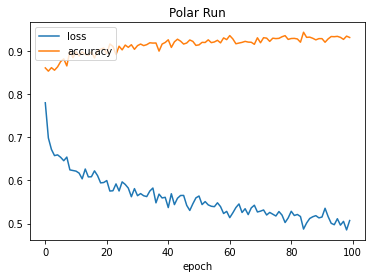

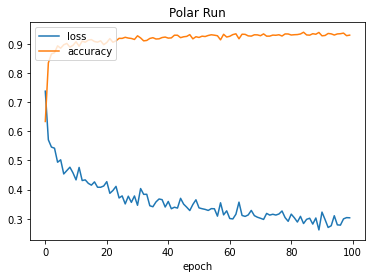

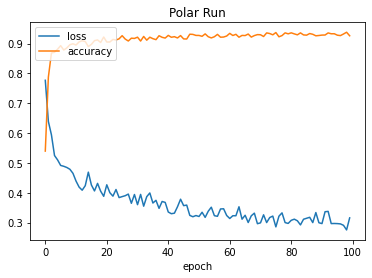

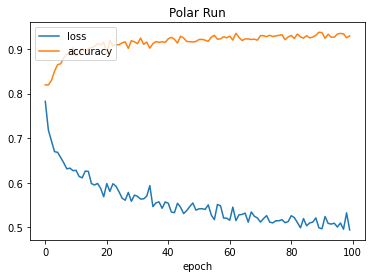

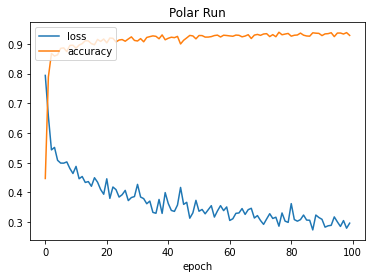

________________________________________________


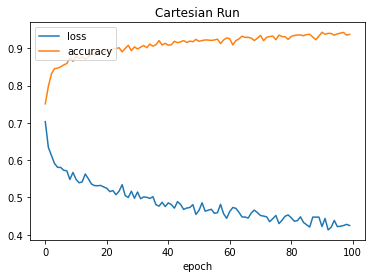

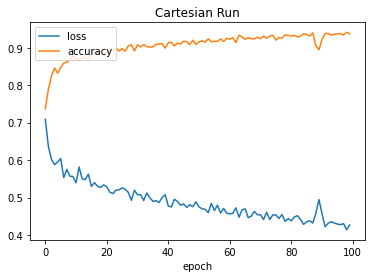

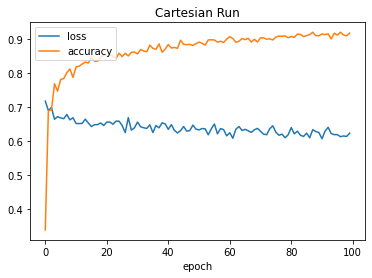

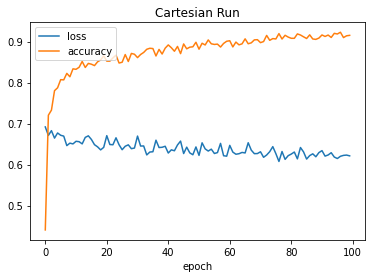

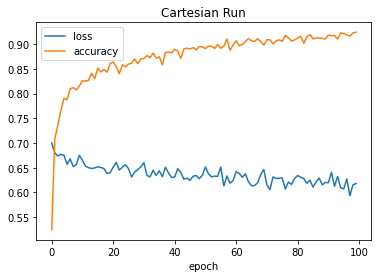

In [10]:
for single_run in Polar_history:
    plt.plot(single_run.history['loss'])
    plt.plot(single_run.history['accuracy'])
    plt.title('Polar Run')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()
print('________________________________________________')
for single_run in Cartesian_history:
    plt.plot(single_run.history['loss'])
    plt.plot(single_run.history['accuracy'])
    plt.title('Cartesian Run')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()

By now, all of the ten models from each group are trained, the next step is to load each of them and predict using every other images that are not in the training set as inputs. Note that `polar dominant models` should only take `polar` images as inputs and `cartesian dominant models` should only take `cartesian` images as inputs. 

This block is supposed to get and check the number of images and masks in the source folder. *could be moved to previous blocks*

In [11]:
#Predict using polar dominant images
image_extension = 'tif'
image_count = 0
img_pattern = os.path.join(PARAM_PATH_POLAR, PARAM_IMG_FOLDER, f'*.{image_extension}')
image_files = glob.glob(img_pattern)
msk_pattern = os.path.join(PARAM_PATH_POLAR, PARAM_MSK_FOLDER, f'*.{image_extension}')
msk_files = glob.glob(msk_pattern)
#length matching check
if len(image_files) == len(msk_files):
    print('WE have a matching number of images and labels here, count = ', len(msk_files))
else:
    print('Something is wrong with the original data set. [Unmatching number of images/masks.]')


WE have a matching number of images and labels here, count =  7404


In [12]:
K = 5 #if we don't want to train again, run this
PARAM_BETA_TEST_NUM = 6

In [13]:
# Create a numpy array to showcase the distribution of files

n = len(image_files)
m = K * 2

filematrix = np.zeros((n,m))
for img_type in ['polar', 'carte']:
    #
    img_extenstion = 'tif'
    #
    for_counter = 0
    if img_type == 'polar':
        working_parent_folder = PARAM_PATH_TEMP_POLAR
    else:
        working_parent_folder = PARAM_PATH_TEMP_CARTE
        for_counter += 1
    for i in range(K):
        image_path = os.path.join(working_parent_folder, str(i), img_type, PARAM_IMG_FOLDER)
        img_pattern = os.path.join(image_path, f'*.{image_extension}')
        image_files = glob.glob(img_pattern)
        for file_name in image_files:
            file_name_shorten = os.path.basename(file_name)
            file_name_raw, ext = os.path.splitext(file_name_shorten)
            filematrix[int(file_name_raw),i + for_counter * K] = 1
        #number_of_ones = np.count_nonzero(filematrix == 1)
        #print(number_of_ones)  #uncomment this line when png file is not satisfactory, we can track the number of ones during each step  
plt.imsave('filematrix.png', filematrix, cmap = 'binary')


#### Here we will have a .png file saved to the root directory, zoom in and we should be able to see only one pixel is colored black in each row.
-------

In [14]:
augmented_filematrix = np.copy(filematrix)
for row in augmented_filematrix:
    for for_counter in range(2):
        zero_count = 0
        for index in range(K):
            real_index = index + for_counter * K
            if row[real_index] == 0:
                zero_count += 1
        if zero_count == 5:
            row[for_counter*K:for_counter*K + 5] = 1
            

In [15]:
row_indices, col_indices = np.where(augmented_filematrix == 1)
indices = list(zip(row_indices, col_indices))

In [156]:
def dice_coefficient(image1, image2):
    # Ensure the input images have the same shape
    smooth = 1
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same shape.")
    img1_f = (image1-1)*(-1)
    img2_f = (image2-1)*(-1)
    # Calculate the intersection (logical AND) between the two binary images
    intersection_o = np.logical_and(image1, image2).sum()
    intersection_f = np.logical_and(img1_f, img2_f).sum()
    # Calculate the sum of pixels in each image
    sum_image1_o = image1.sum()
    sum_image2_o = image2.sum()
    sum_image1_f = img1_f.sum()
    sum_image2_f = img2_f.sum()
    #if(sum_image1 == sum_image2 == 0):#I'm not so sure about this o.0
        #return 1.0
    # Calculate the Dice coefficient
    dice = (2.0 * intersection_o + smooth) / (sum_image1_o + sum_image2_o + smooth)
    dice_f = (2.0 * intersection_f + smooth) / (sum_image1_f + sum_image2_f + smooth)
    dice_avg = (dice + dice_f) / 2.0
    return dice_avg


In the next block, we will loop through all sub folders, register all images appears in the training set, and reverse, and take the images from that specific big class, directly from the original data folder, and throw them to a temporary folder.

Now that we have the `filematrix`, we can go over each coloumn, pull out files into a temporary folder and make a round of prediction using that model if the value is 0.

In [157]:

scorematrix = np.zeros((n,m))
for img_type in ['polar', 'carte']:
    for_counter = 0
    if img_type == 'polar':
        working_parent_folder = PARAM_PATH_TEMP_POLAR
        src_folder = PARAM_PATH_POLAR
    else:
        working_parent_folder = PARAM_PATH_TEMP_CARTE
        src_folder = PARAM_PATH_CARTE
        for_counter += 1
    for i in range(K):
        current_folder_index = i + for_counter * K
        temp_test_folder_name = 'temptest'
        #print(working_parent_folder)
        if os.path.exists(temp_test_folder_name):
            shutil.rmtree(temp_test_folder_name)
        temp_test_img_folder = os.path.join(temp_test_folder_name,PARAM_IMG_FOLDER)
        temp_test_msk_folder = os.path.join(temp_test_folder_name,PARAM_MSK_FOLDER)
        os.makedirs(temp_test_img_folder)
        os.makedirs(temp_test_msk_folder)
        for indice in indices:
            if indice[1] == current_folder_index:
                img_name = str(indice[0]) + '.' + img_extenstion
                src = os.path.join(src_folder,PARAM_IMG_FOLDER,img_name)
                shutil.copy2(src, temp_test_img_folder)
                src = os.path.join(src_folder,PARAM_MSK_FOLDER,img_name)
                shutil.copy2(src, temp_test_msk_folder)
        
        model_path = os.path.join(working_parent_folder, str(i), 'checkpoint.hdf5')
        current_model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM])
        current_model.load_weights(model_path) 
        for test_image_name in os.listdir(temp_test_img_folder):
            test_image_name_raw, ext = os.path.splitext(test_image_name)
            image_path = os.path.join(temp_test_img_folder, test_image_name)
            ground_truth_mask_path = os.path.join(temp_test_msk_folder, test_image_name)
            
            test_image = cv2.imread(image_path)
            test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
            test_image = test_image / 255.0
            test_image = np.expand_dims(test_image,axis = 0)

            ground_truth_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
            ground_truth_mask = ground_truth_mask / 255.0
            ground_truth_mask = ground_truth_mask.astype(np.uint8)
            
            prediction = current_model.predict(test_image, verbose = 0)
            
            threshold = 0.5
            binary_mask = (prediction > threshold).astype(np.uint8)
            binary_mask = binary_mask[0,:,:,0]
            dice = dice_coefficient(ground_truth_mask, binary_mask)
            scorematrix[int(test_image_name_raw), current_folder_index] = dice
        print('Done with folder ', current_folder_index)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Done with folder  0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When

Done with folder  8
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Done with folder  9


#### Now compare the scores of each row and see which one big group it should belong

In [158]:
#This block contains the code to decide if one img should stay in its own group by looking for the absolute maximum performance
decision = np.zeros(n)
current_i = 0
for score_row, file_row in zip(scorematrix, filematrix):
    if(np.argmax(score_row) != np.argmax(file_row)):
        if(np.argmax(file_row) >= K):#need to move from polar to cartesian
            decision[current_i] = 1
        else:
            decision[current_i] = -1
    current_i += 1

The number of moving: polar -> cartesian:  1906
The number of moving: cartesian -> polar:  2774


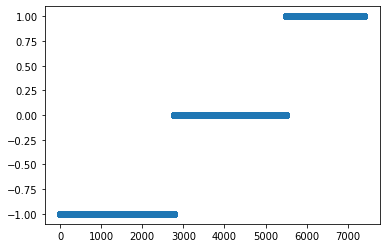

In [159]:
number_of_ones_decision = np.count_nonzero(decision == 1)
print('The number of moving: polar -> cartesian: ', number_of_ones_decision)
number_of_minusones_decision = np.count_nonzero(decision == -1)
print('The number of moving: cartesian -> polar: ', number_of_minusones_decision)
plt.plot(np.sort(decision),'o')

#### Actually, what if I just make the result into another list of dice score, and sort on this numpy list to do the next round of training?

(7404, 1)


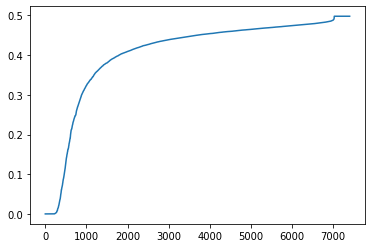

In [165]:
x_range = 7404
merged_score = np.copy(scorematrix)
max_values = np.max(merged_score, axis=1)
max_values = max_values[:,np.newaxis]
#plt.plot(merged_score)
sorted_merged_score = np.sort(max_values,0)
plt.plot(sorted_merged_score[0:x_range])
print(sorted_merged_score.shape)

In [170]:
row_count = 0
z_count = 0
for row in scorematrix:
    if np.max(row) == 0.5:
        z_count += 1
        print(np.max(row))
    row_count += 1
print('---:', z_count)

0.23310156713775435
0.44736828661459116
0.3096427226198024
0.2559900058953482
0.03626361391255759
0.43021125655664605
0.059992009588646436
0.1428627133978799
0.184223921511658
0.15114664957087978
0.2473492867895083
0.21307283667623417
0.31397804615000224
0.4330708322639421
0.280930370079579
0.2027048328319508
0.46232471623814525
0.45625666871975357
0.0
0.45787643943180767
0.4261766094033113
0.44699222478915024
0.44486927410320587
0.4193239539763728
0.37199459519691996
0.43888135814590595
0.47278433224718636
0.4590184221918234
0.3872730737620262
0.4980392006680118
0.34382946303394496
0.287797692432656
0.33100110600740884
0.3953398757675176
0.3882406697201025
0.40502973596200204
0.4672913844380256
0.4496488179323277
0.3963923968468292
0.4041203613944713
0.4223039611435053
0.4545409003104881
0.4150533219976556
0.33876306756733804
0.37578470592470015
0.35939936047752935
0.34208473372594594
0.2430279209590567
0.4675867066923743
0.058232627674294594
0.2947601446079207
0.41716349307963574
0.4

In [161]:
max_loc = np.zeros(n)
loc = 0
for eachrow in merged_score:
    max_loc[loc] = np.argmax(eachrow)
    loc += 1

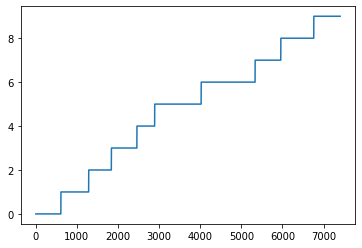

In [162]:
plt.plot(np.sort(max_loc))

0.6541286785479757


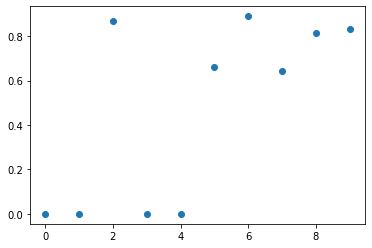

In [144]:
plt.plot(merged_score[1212], 'o')
print(merged_score[168][0])

In [155]:
for i in decision:
    if i==-1:
        new_data_i = os.path.join(working_parent_folder, str(i), PARAM_SUB_FOLDER_POLAR)
        temp_folder_path = os.path.join(working_parent_folder,'temp')
        os.mkdir(temp_folder_path)
        os.mkdir()

[-1. -1.  1. ...  0.  0.  0.]
